In [21]:
import sys
sys.path.insert(0, '../../..')
# from Practice.Utils.metrics import evaluate_classification
# from Practice.Utils.plots import plot_decision_boundary, plot_data

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
def evaluate_classification(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    return accuracy, report, confusion

In [23]:
def plot_decision_boundary(clf, X, y):
    # Define the range of values for the features
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Use the classifier to predict the class of each point in the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary and the data points
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision boundary')

In [24]:
def plot_data(X, y):
    plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
    plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [25]:
   
class NeuralNet:
    def __init__(self, hidden_layers_sizes=[10, 100], normalize=True, learning_rate=0.01, num_iter=30000, reg_lambda=0, activation='sigmoid', early_stop=False):
        self.hidden_layers_sizes = hidden_layers_sizes
        self.normalize = normalize
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.reg_lambda = reg_lambda
        self.activation = activation
        self.early_stop = early_stop
        self.cost_history = []
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def __tanh(self, Z):
        return np.tanh(Z)

    def __relu(self, Z):
        return np.maximum(0, Z)

    def __initialize_parameters(self, n_x, n_1):
        n_h = len(self.hidden_layers_sizes)
        sizes = [n_x] + self.hidden_layers_sizes + [1]
        self.params = {}
        for i in range(1, n_h+2):
            self.params[f"W{i}"] = np.random.randn(sizes[i], sizes[i - 1]) * 0.01
            self.params[f"b{i}"] = np.zeros((sizes[i], 1))
    
    def __forward_propagation(self, X):
        cache = {"A0": X}
        n_h = len(self.hidden_layers_sizes)

        for i in range(1, n_h+2):
            W = self.params[f"W{i}"]
            b = self.params[f"b{i}"]
            A_prev = cache[f"A{i-1}"]
            Z = np.dot(W, A_prev) + b

            if self.activation == 'sigmoid':
                A = self.__sigmoid(Z)
            elif self.activation == 'tanh':
                A = self.__tanh(Z)
            elif self.activation == 'relu':
                A = self.__relu(Z)

            cache[f"Z{i}"] = Z
            cache[f"A{i}"] = A

        return A, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)

        for i in range(1, len(self.hidden_layers_sizes)+2):
            W = self.params[f"W{i}"]
            J += self.reg_lambda / 2 * m * np.sum(W * W)
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        grads = {}
        n_h = len(self.hidden_layers_sizes)
        dZ = cache[f"A{n_h+1}"] - Y
        

        grads[f"dW{n_h+1}"] = np.dot(dZ, cache[f"A{n_h}"].T) / m
        self.params[f"W{n_h+1}"] = (1 - self.learning_rate * self.reg_lambda / m) * self.params[f"W{n_h+1}"] - self.learning_rate * grads[f"dW{n_h+1}"]

        grads[f"db{n_h+1}"] = np.sum(dZ, axis=1, keepdims=True) / m
        self.params[f"b{n_h+1}"] = self.params[f"b{n_h+1}"] - self.learning_rate * grads[f"db{n_h+1}"] 

        for i in range(n_h, 0, -1):
            W_next = self.params[f"W{i+1}"]
            dZ_next = dZ
            A = cache[f"A{i}"]

            if self.activation == 'sigmoid':
                dZ = np.dot(W_next.T, dZ_next) * A * (1 - A)
            elif self.activation == 'tanh':
                dZ = np.dot(W_next.T, dZ_next) * (1 - np.power(A, 2))
            elif self.activation == 'relu':
                dZ = np.dot(W_next.T, dZ_next) * (A > 0)

            grads[f"dW{i}"] = np.dot(dZ, cache[f"A{i-1}"].T) / m
            self.params[f"W{i}"] = (1 - self.learning_rate * self.reg_lambda / m) * self.params[f"W{i}"] - self.learning_rate * grads[f"dW{i}"]

            grads[f"db{i}"] = np.sum(dZ, axis=1, keepdims=True) / m
            self.params[f"b{i}"] = self.params[f"b{i}"] - self.learning_rate * grads[f"db{i}"] 
        return grads
    
    def __update_parameters(self, grads):
        n_h = len(self.hidden_layers_sizes)
        for i in range(1, n_h+2):
            self.params[f"W{i}"] -= self.learning_rate * grads[f"dW{i}"]
            self.params[f"b{i}"] -= self.learning_rate * grads[f"db{i}"]

    def fit(self, X_vert, Y_vert, print_cost = True):
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)

        costs = []
        
        n_x, n_1 = X.shape[0], self.hidden_layers_sizes[0]
        self.__initialize_parameters(n_x, n_1)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            cost = self.compute_cost(A, Y)
            grads = self.__backward_propagation(X, Y, cache)
            self.__update_parameters(grads)
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

            if i > 100 and np.mean(costs[-10:]) >= np.mean(costs[-20:-10]):
                print(f"Early stopping after iteration {i}.")
                break
        
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((1 - probs.T, probs.T))

    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 1]
        return (positive_probs >= 0.5).astype(int)

# Симульовані дані 1

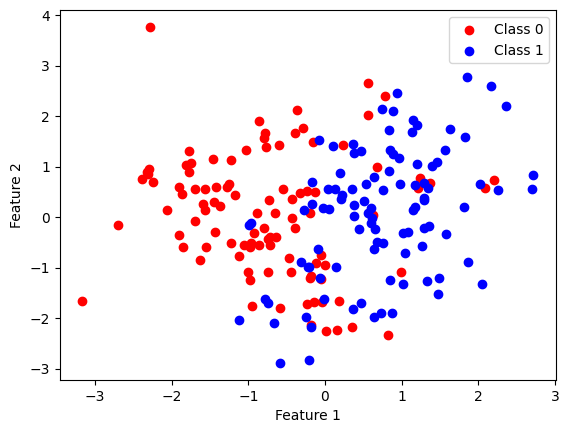

0-th iteration: 0.6940923744893742


c:\Users\kolya\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kolya\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1000-th iteration: 0.6937670033916488
2000-th iteration: 0.6937681501180023
3000-th iteration: 0.6937745333926221
4000-th iteration: 0.6937886906829822
5000-th iteration: 0.6938165167696064
6000-th iteration: 0.6938709073807289
7000-th iteration: 0.693982250748219
8000-th iteration: 0.6942348282783182
9000-th iteration: 0.694936133353339
10000-th iteration: 0.6977209941390577
Early stopping after iteration 10000.


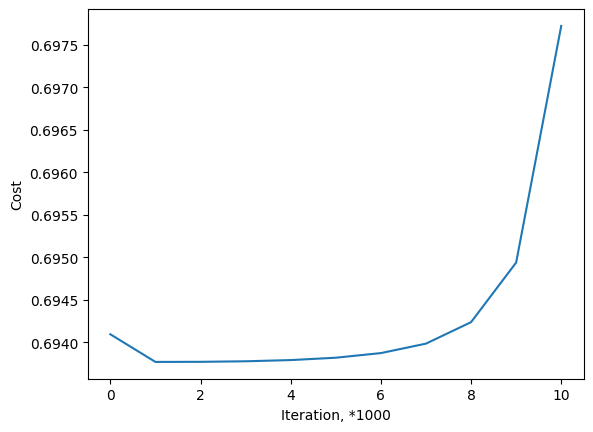

Accuracy: 
0.45
Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.45      1.00      0.62        18

    accuracy                           0.45        40
   macro avg       0.23      0.50      0.31        40
weighted avg       0.20      0.45      0.28        40

Confusion: 
[[ 0 22]
 [ 0 18]]


c:\Users\kolya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kolya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kolya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

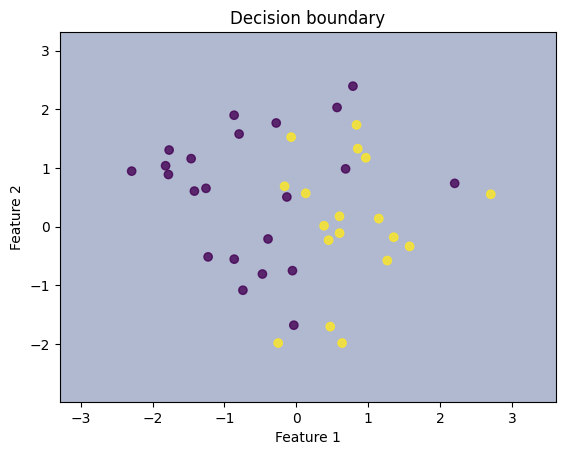

In [26]:
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)
plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet(early_stop=True, learning_rate=0.05, reg_lambda=0.0001, num_iter=25000, activation='sigmoid')
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Симульовані дані 2

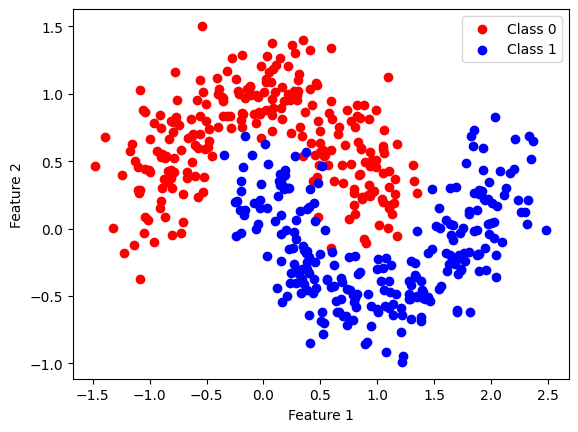

0-th iteration: 0.6971269294026321


c:\Users\kolya\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kolya\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1000-th iteration: 2.2743090941176467
2000-th iteration: 2.462955418595978
3000-th iteration: 2.6289457748124487
4000-th iteration: 3.9895195288312686
5000-th iteration: 7.264762587363482
6000-th iteration: 8.283938071896532
7000-th iteration: 9.422420515736068
8000-th iteration: 10.644264051800157
9000-th iteration: 12.023809678152325
10000-th iteration: 13.338886173787124
Early stopping after iteration 10000.


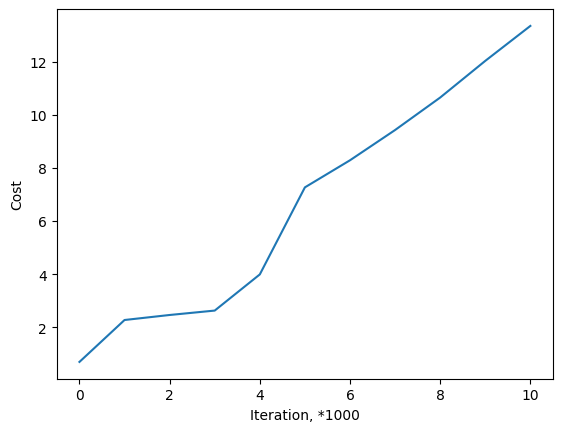

Accuracy: 
0.98
Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        43
           1       1.00      0.96      0.98        57

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

Confusion: 
[[43  0]
 [ 2 55]]


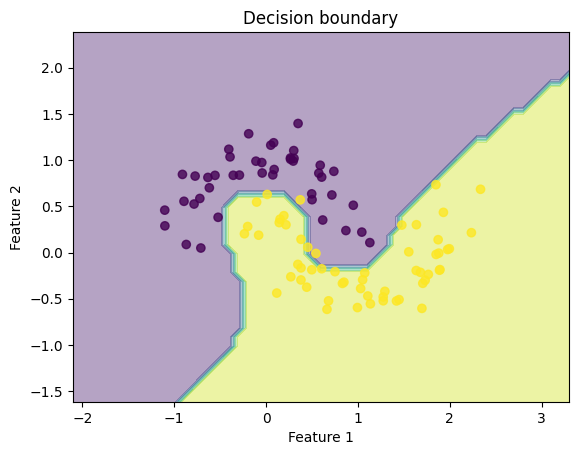

In [27]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet(learning_rate = 0.5, reg_lambda=0.0001)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

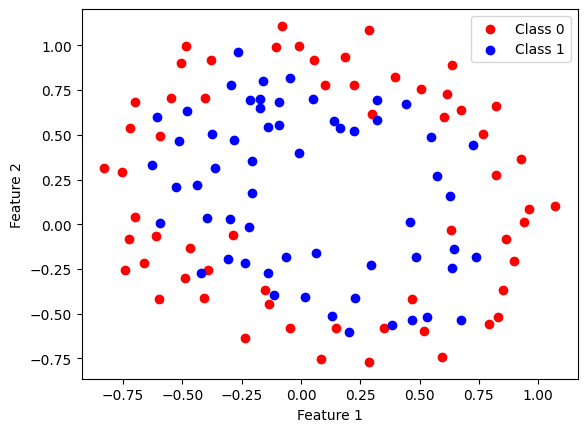

In [28]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column].values

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

0-th iteration: 0.6933302471238738


c:\Users\kolya\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kolya\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1000-th iteration: 0.5826142364055044
2000-th iteration: 0.3601349985114818
3000-th iteration: 0.32433401727451716
4000-th iteration: 0.3042388587664597
5000-th iteration: 0.2863255494288956
6000-th iteration: 0.2709558596564117
7000-th iteration: 0.2592539148100529
8000-th iteration: 0.2488333446163085
9000-th iteration: 0.24158218252264396
10000-th iteration: 0.23614679339749337
11000-th iteration: 0.23173698640597584
12000-th iteration: 0.2275704053797476
13000-th iteration: 0.2236486654281819
14000-th iteration: 0.22014636331982396
15000-th iteration: 0.21662526463587742
16000-th iteration: 0.21298162535467705
17000-th iteration: 0.20927304606983543
18000-th iteration: 0.20538834429120906
19000-th iteration: 0.20115431421274046


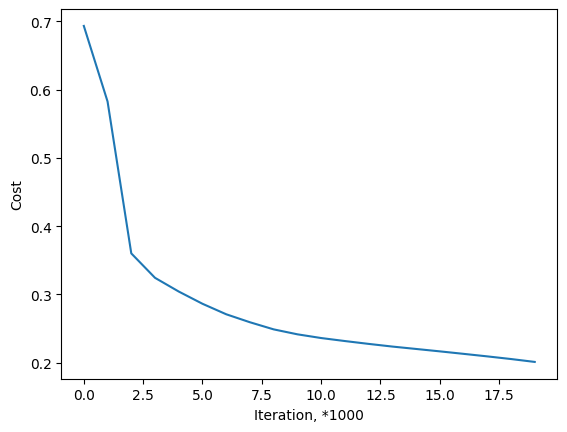

Accuracy: 
0.75
Report: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.75      0.75      0.75        12

    accuracy                           0.75        24
   macro avg       0.75      0.75      0.75        24
weighted avg       0.75      0.75      0.75        24

Confusion: 
[[9 3]
 [3 9]]


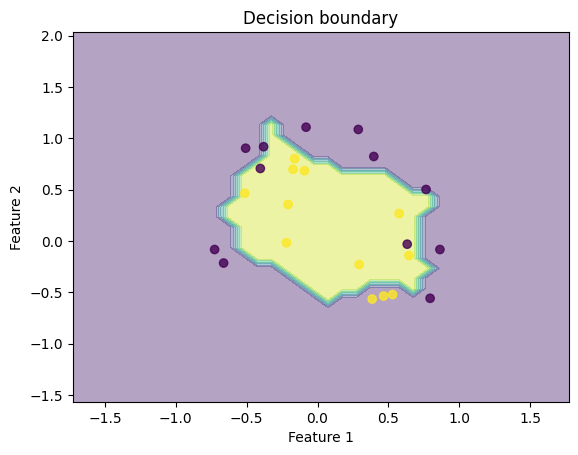

In [29]:
nn = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 20000, hidden_layers_sizes=[20])
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

In [30]:
print(nn.params)

{'W1': array([[  7.17665456,   1.70299941],
       [ -1.22190968,   0.59799492],
       [  0.24167963,  -0.48316537],
       [ -0.46224814,   0.19808876],
       [  4.55660855,   5.46608159],
       [ -5.39658001,   0.10229639],
       [  4.70714589,  -4.68626439],
       [ -0.81815668,   3.89240122],
       [ -2.10503526,   1.67454683],
       [ -4.82236381, -13.07800952],
       [ -1.52771232,   0.86379425],
       [ -0.80786713,   3.77147929],
       [ -5.07119552,   8.15072807],
       [ -0.38216704,   0.17094531],
       [ -3.51127186,  -4.34677498],
       [-13.76900417,  -3.19201699],
       [ -0.9870203 ,   0.49333176],
       [-11.21060433,  -9.00918131],
       [ -1.98924176,  14.22689086],
       [ -1.23960564,   0.6077568 ]]), 'b1': array([[-9.70407716],
       [ 0.16805108],
       [ 0.72132282],
       [ 0.12188767],
       [ 1.92823287],
       [-8.93509968],
       [-6.22052164],
       [-5.77667628],
       [ 1.38815837],
       [-4.67918014],
       [ 0.46775277],
   

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

Accuracy: 
0.7083333333333334
Report: 
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.69      0.75      0.72        12

    accuracy                           0.71        24
   macro avg       0.71      0.71      0.71        24
weighted avg       0.71      0.71      0.71        24

Confusion: 
[[8 4]
 [3 9]]


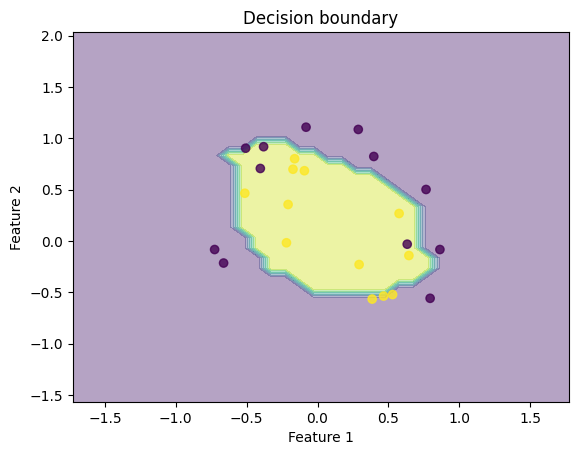

In [31]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(clf, X_test, y_test)
plt.show()

In [32]:
clf.n_iter_

1431